# Improved ResNet for CIFAR-10 with SWA & Mixup
This notebook demonstrates training an improved ResNet on the CIFAR-10 dataset using data augmentation, mixup, and Stochastic Weight Averaging (SWA). The training and evaluation metrics are plotted, and the final test accuracy and number of parameters are printed.


In [1]:
# Import Libraries
import os
import pickle
import time
import math
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from torch.optim.swa_utils import AveragedModel, update_bn

### Load and Display Sample Training Images

In [2]:
# List all files available in the Kaggle input directory
for dirname, _, filenames in os.walk('/kaggle/input/deep-learning-spring-2025-project-1/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [3]:
# Data Loading Utility Functions
def load_cifar_batch(file_path):
    """Load a single CIFAR-10 batch file using pickle."""
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

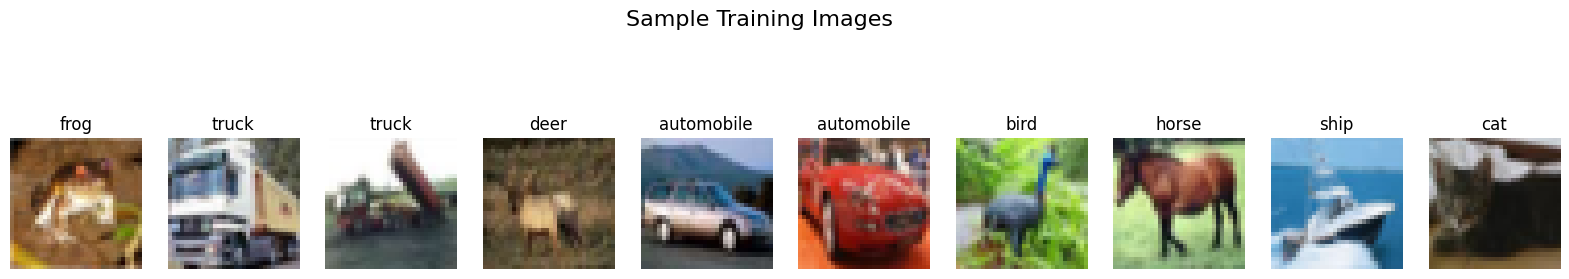

In [4]:
# Set CIFAR-10 directory
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load class label names
meta_data = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data[b'label_names']

# Load one batch for demonstration
batch1 = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch1[b'data']
train_labels = batch1[b'labels']

# Reshape images for display (from [10000, 3, 32, 32] to [10000, 32, 32, 3])
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))
    plt.axis('off')
plt.suptitle("Sample Training Images", fontsize=16)
plt.show()

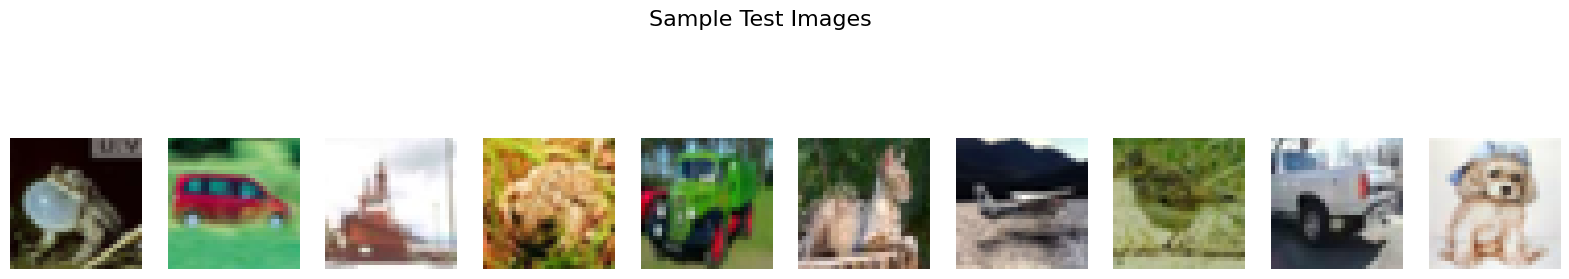

In [5]:
# Load and Display Sample Test Images
test_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')
images = test_batch[b'data']

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Sample Test Images", fontsize=16)
plt.show()

## Setup fixed seed for reproducibility and set device parameter to use cuda device if available

In [6]:
# Set Random Seed and Device
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Data

In [8]:
# Full CIFAR-10 Data Loading Function
def load_cifar_data():
    cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'
    
    # Load training data from all batches
    x_train, y_train = [], []
    for i in range(1, 6):
        batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
        batch_data = load_cifar_batch(batch_file)
        if i == 1:
            x_train = batch_data[b'data']
            y_train = batch_data[b'labels']
        else:
            x_train = np.vstack((x_train, batch_data[b'data']))
            y_train.extend(batch_data[b'labels'])
    
    x_train = x_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    y_train = np.array(y_train)
    
    # Load test data
    test_batch_file = os.path.join(cifar10_dir, 'test_batch')
    test_data = load_cifar_batch(test_batch_file)
    x_test = test_data[b'data'].reshape(-1, 3, 32, 32).astype('float32') / 255.0
    y_test = np.array(test_data[b'labels'])
    
    # Load class names
    meta_data = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
    class_names = [label.decode('utf-8') for label in meta_data[b'label_names']]
    
    return (x_train, y_train), (x_test, y_test), class_names

In [9]:
# Load the full CIFAR-10 dataset
(x_train, y_train), (x_test, y_test), class_names = load_cifar_data()
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Create DataLoaders with Data Augmentation
def get_data_loaders(x_train, y_train, x_test, y_test, batch_size=128):
    # Transformations for training images
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.transpose(1, 2, 0)),  # Change from channels-first to channels-last
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    # Transformations for test images (no augmentation)
    test_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.transpose(1, 2, 0)),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])
    
    class CIFAR10Dataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform
        
        def __len__(self):
            return len(self.labels)
        
        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
    
    train_dataset = CIFAR10Dataset(x_train, y_train, transform=train_transform)
    test_dataset = CIFAR10Dataset(x_test, y_test, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

Training data shape: (50000, 3, 32, 32)
Test data shape: (10000, 3, 32, 32)


In [10]:
train_loader, test_loader = get_data_loaders(x_train, y_train, x_test, y_test, batch_size=128)

## Squeeze-and-Excitation Module

The `SqueezeExcitation` class implements the Squeeze-and-Excitation (SE) block, a channel attention mechanism that adaptively recalibrates channel-wise feature responses. This module first "squeezes" spatial information via global average pooling, then "excites" channel-wise dependencies through two fully-connected layers with a bottleneck structure. The initial dimensionality reduction (controlled by the `reduction` parameter, default 16) helps limit model complexity while the final sigmoid activation produces channel-specific scaling factors between 0 and 1. These scaling factors are then multiplied with the original feature maps, allowing the network to emphasize informative features and suppress less useful ones. SE blocks have been shown to significantly improve model performance across various computer vision tasks with minimal additional computational cost.

In [11]:
# Define the Model Architecture
class SqueezeExcitation(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

## Bottleneck Block with Squeeze-and-Excitation

The `BottleneckBlock` class implements a fundamental building block for efficient deep residual networks with integrated attention mechanisms. This architecture follows the classic bottleneck design with three convolutional layers: a 1×1 projection to reduce dimensionality, a 3×3 spatial convolution that captures local patterns, and another 1×1 convolution that restores dimensionality to `out_channels * expansion` (typically 4×). Each convolution is followed by batch normalization and ReLU activation, with the exception of the final activation which occurs after the residual connection. The block incorporates a Squeeze-and-Excitation (SE) module between the third convolution and the residual addition, enabling channel-wise recalibration of features. This adaptive weighting mechanism helps the network focus on the most informative features while suppressing less useful ones. When spatial dimensions need to be reduced (i.e., when `stride > 1`), the optional `downsample` module ensures dimensional compatibility for the residual connection.

In [12]:
# Bottleneck block with squeeze-and-excitation.
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu  = nn.ReLU(inplace=True)
        self.se    = SqueezeExcitation(out_channels * self.expansion, reduction=16)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

## ImprovedResNet Implementation

The `ImprovedResNet` class has the following features from ResNet implementations and some that differ:

1. **Increasing Channel Growth**: The network starts with 32 channels and increases to 238 channels in the final layer and keeps the parameter count under 5M.

2. **Strategic Dropout Placement**: Dropout layers are between residual blocks with increasing rates (from 0.1 to 0.3), with the final classifer having larger value to prevent overfitting.

3. **Efficient Initial Layers**: Uses a 3×3 convolution with stride 1 instead of the larger 7×7 filters with stride 2 found in the original ResNet.

4. **Weight Initialization**: Employs Kaiming initialization for convolutional layers to ensure stable gradient flow during training.

5. **Integrated Attention Mechanism**: Every bottleneck block has a Squeeze-and-Excitation module, that allows dynamic feature importance to be incorporated along the way.

## Network Flow

1. Initial 3×3 convolution processes the input image (3 channels) and outputs 32 feature maps
2. Four residual layers with increasing channel dimensions (32 → 64 → 128 → 238)
3. Dropout layers between stages with increasing higher rates to regularize deeper layers
4. Global average pooling to condense spatial dimensions before classification
5. Final dropout layer followed by a FC layer which produces class probabilities after softmax.

In [13]:
# Improved ResNet architecture with dropout and SE modules.
class ImprovedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.2):
        super(ImprovedResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(self.in_channels)
        self.relu  = nn.ReLU(inplace=True)
        
        # Residual layers with dropout in between
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1)
        self.dropout1 = nn.Dropout(dropout_rate/2)
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.dropout2 = nn.Dropout(dropout_rate/2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.layer4 = self._make_layer(block, 238, layers[3], stride=2)  # 238 chosen to keep parameters under 5M
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_final = nn.Dropout(dropout_rate * 1.5)
        self.fc = nn.Linear(238 * block.expansion, num_classes)
        
        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.dropout3(x)
        x = self.layer4(x)
        x = self.dropout4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_final(x)
        x = self.fc(x)
        return x

In [14]:
# Return the number of trainable parameters.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and Evaluation Functions

In [15]:
# Train the model for one epoch. Optionally applies mixup data augmentation.
def train(model, train_loader, optimizer, criterion, device, use_mixup=True, alpha=0.2):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        if use_mixup and alpha > 0:
            lam = np.random.beta(alpha, alpha)
            batch_size = inputs.size(0)
            index = torch.randperm(batch_size).to(device)
            mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
            
            outputs = model(mixed_inputs)
            loss = lam * criterion(outputs, targets) + (1 - lam) * criterion(outputs, targets[index])
            
            # For accuracy, use the unmixed inputs
            with torch.no_grad():
                unmixed_outputs = model(inputs)
                _, predicted = unmixed_outputs.max(1)
                correct += predicted.eq(targets).sum().item()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total += targets.size(0)
        
    return running_loss / len(train_loader), 100. * correct / total

In [16]:
# Evaluate the model on the test set.
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(test_loader), 100. * correct / total

In [17]:
# Return a learning rate scheduler with warmup and cosine annealing.
def get_lr_scheduler(optimizer, warmup_epochs=5, total_epochs=300):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs  # linear warmup
        return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


## Model Training Setup and model summary

In [18]:
# Create the model using Bottleneck blocks (3 blocks per layer)
model = ImprovedResNet(BottleneckBlock, [3, 3, 3, 3], num_classes=10, dropout_rate=0).to(device)

In [19]:
# Count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params:,}")
print("Parameter limit: 5,000,000")
assert num_params < 5000000, "Model has too many parameters!"

Number of trainable parameters: 4,988,974
Parameter limit: 5,000,000


In [20]:
try:
    from torchsummary import summary
    summary(model, (3, 32, 32))
except ImportError:
    print("torchsummary not available. Skipping model summary.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           1,024
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]           4,096
      BatchNorm2d-11          [-1, 128, 32, 32]             256
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                    [-1, 8]           1,024
             ReLU-14                   

## Optimizer and lr scheduler
We have used SGD with momentum as it yielded the best results. We took the initial lr as `0.05`.
For lr-scheduling we have used LambdaLR with `warmup_epochs=5`. The lambda method does cosine annealing with initial warmup. This ensures that the learning rate keeps decreasing so the model
progressing gets optimized and converges properly.

In [21]:
# Set up optimizer, learning rate scheduler, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-3)
scheduler = get_lr_scheduler(optimizer, warmup_epochs=5, total_epochs=300)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

## Stochastic Weight Averaging (SWA)
We do a weight averaging of all model weights after recording all weights starting from 240 epochs. In research, this has been shown to yield slightly better test accuracies so we decided to add this.
The research literature suggests starting around 80% mark, hence we start around `240` for total `300` epochs

In [22]:
# Set up Stochastic Weight Averaging (SWA)
swa_model = AveragedModel(model)
swa_start = 240  # Start SWA after this epoch

## Training Loop
We train the model for 300 epochs and store the best test accuracy.

In [23]:
num_epochs = 300
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_train_acc, best_test_acc = 0.0, 0.0
best_model_state = None
patience = 50
patience_counter = 0
swa_active = False

print(f"Starting training for {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if epoch >= swa_start:
        if not swa_active:
            print("Activating Stochastic Weight Averaging (SWA).")
            swa_active = True
        swa_model.update_parameters(model)
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_train_acc = train_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best: Train Acc = {best_train_acc:.2f}% | Test Acc = {best_test_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
    
    if patience_counter >= patience:
        print("No improvement for a while. Early stopping triggered!")
        break

Starting training for 300 epochs...

Epoch 1/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3840 | Train Acc: 11.46%
Test Loss: 2.4101 | Test Acc: 12.37%
Current LR: 0.010000
New best: Train Acc = 11.46% | Test Acc = 12.37%

Epoch 2/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.1357 | Train Acc: 26.21%
Test Loss: 1.8266 | Test Acc: 37.97%
Current LR: 0.020000
New best: Train Acc = 26.21% | Test Acc = 37.97%

Epoch 3/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.9396 | Train Acc: 36.82%
Test Loss: 1.6925 | Test Acc: 45.27%
Current LR: 0.030000
New best: Train Acc = 36.82% | Test Acc = 45.27%

Epoch 4/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.8177 | Train Acc: 45.01%
Test Loss: 1.4942 | Test Acc: 54.97%
Current LR: 0.040000
New best: Train Acc = 45.01% | Test Acc = 54.97%

Epoch 5/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.6749 | Train Acc: 52.90%
Test Loss: 1.3824 | Test Acc: 60.82%
Current LR: 0.050000
New best: Train Acc = 52.90% | Test Acc = 60.82%

Epoch 6/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.6027 | Train Acc: 57.93%
Test Loss: 1.3248 | Test Acc: 62.17%
Current LR: 0.049999
New best: Train Acc = 57.93% | Test Acc = 62.17%

Epoch 7/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5242 | Train Acc: 62.54%
Test Loss: 1.3060 | Test Acc: 63.24%
Current LR: 0.049994
New best: Train Acc = 62.54% | Test Acc = 63.24%

Epoch 8/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4722 | Train Acc: 66.32%
Test Loss: 1.1815 | Test Acc: 70.65%
Current LR: 0.049987
New best: Train Acc = 66.32% | Test Acc = 70.65%

Epoch 9/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4297 | Train Acc: 68.88%
Test Loss: 1.2624 | Test Acc: 67.07%
Current LR: 0.049977
No improvement for 1 epoch(s).

Epoch 10/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3902 | Train Acc: 70.74%
Test Loss: 1.1227 | Test Acc: 72.57%
Current LR: 0.049965
New best: Train Acc = 70.74% | Test Acc = 72.57%

Epoch 11/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3585 | Train Acc: 71.64%
Test Loss: 1.1068 | Test Acc: 72.93%
Current LR: 0.049949
New best: Train Acc = 71.64% | Test Acc = 72.93%

Epoch 12/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3495 | Train Acc: 72.46%
Test Loss: 1.1420 | Test Acc: 71.72%
Current LR: 0.049931
No improvement for 1 epoch(s).

Epoch 13/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3354 | Train Acc: 73.56%
Test Loss: 1.1340 | Test Acc: 71.42%
Current LR: 0.049909
No improvement for 2 epoch(s).

Epoch 14/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3226 | Train Acc: 73.81%
Test Loss: 1.0259 | Test Acc: 77.27%
Current LR: 0.049885
New best: Train Acc = 73.81% | Test Acc = 77.27%

Epoch 15/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3404 | Train Acc: 73.83%
Test Loss: 1.0821 | Test Acc: 75.31%
Current LR: 0.049858
No improvement for 1 epoch(s).

Epoch 16/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3092 | Train Acc: 74.21%
Test Loss: 1.1280 | Test Acc: 72.41%
Current LR: 0.049829
No improvement for 2 epoch(s).

Epoch 17/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3071 | Train Acc: 74.57%
Test Loss: 0.9918 | Test Acc: 78.58%
Current LR: 0.049796
New best: Train Acc = 74.57% | Test Acc = 78.58%

Epoch 18/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3252 | Train Acc: 75.17%
Test Loss: 1.0692 | Test Acc: 75.19%
Current LR: 0.049761
No improvement for 1 epoch(s).

Epoch 19/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2888 | Train Acc: 74.97%
Test Loss: 1.0246 | Test Acc: 77.48%
Current LR: 0.049723
No improvement for 2 epoch(s).

Epoch 20/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3054 | Train Acc: 75.12%
Test Loss: 1.1999 | Test Acc: 68.92%
Current LR: 0.049682
No improvement for 3 epoch(s).

Epoch 21/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3011 | Train Acc: 75.58%
Test Loss: 1.1146 | Test Acc: 73.09%
Current LR: 0.049638
No improvement for 4 epoch(s).

Epoch 22/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2918 | Train Acc: 75.62%
Test Loss: 0.9922 | Test Acc: 78.48%
Current LR: 0.049591
No improvement for 5 epoch(s).

Epoch 23/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2996 | Train Acc: 75.90%
Test Loss: 1.0571 | Test Acc: 74.79%
Current LR: 0.049542
No improvement for 6 epoch(s).

Epoch 24/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.3018 | Train Acc: 75.90%
Test Loss: 1.0575 | Test Acc: 75.48%
Current LR: 0.049490
No improvement for 7 epoch(s).

Epoch 25/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2752 | Train Acc: 75.95%
Test Loss: 1.0382 | Test Acc: 76.51%
Current LR: 0.049435
No improvement for 8 epoch(s).

Epoch 26/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2749 | Train Acc: 76.45%
Test Loss: 0.9887 | Test Acc: 78.49%
Current LR: 0.049377
No improvement for 9 epoch(s).

Epoch 27/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2881 | Train Acc: 76.41%
Test Loss: 1.0021 | Test Acc: 78.09%
Current LR: 0.049317
No improvement for 10 epoch(s).

Epoch 28/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2730 | Train Acc: 76.25%
Test Loss: 1.0793 | Test Acc: 74.76%
Current LR: 0.049254
No improvement for 11 epoch(s).

Epoch 29/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2530 | Train Acc: 76.79%
Test Loss: 0.9530 | Test Acc: 80.28%
Current LR: 0.049188
New best: Train Acc = 76.79% | Test Acc = 80.28%

Epoch 30/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2612 | Train Acc: 76.46%
Test Loss: 0.9640 | Test Acc: 79.15%
Current LR: 0.049119
No improvement for 1 epoch(s).

Epoch 31/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2459 | Train Acc: 76.67%
Test Loss: 1.0295 | Test Acc: 77.05%
Current LR: 0.049048
No improvement for 2 epoch(s).

Epoch 32/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2398 | Train Acc: 76.97%
Test Loss: 1.0089 | Test Acc: 78.36%
Current LR: 0.048974
No improvement for 3 epoch(s).

Epoch 33/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2584 | Train Acc: 77.09%
Test Loss: 0.9901 | Test Acc: 78.73%
Current LR: 0.048897
No improvement for 4 epoch(s).

Epoch 34/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2436 | Train Acc: 76.90%
Test Loss: 1.0424 | Test Acc: 75.66%
Current LR: 0.048817
No improvement for 5 epoch(s).

Epoch 35/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2406 | Train Acc: 77.29%
Test Loss: 0.9783 | Test Acc: 79.24%
Current LR: 0.048735
No improvement for 6 epoch(s).

Epoch 36/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2366 | Train Acc: 77.26%
Test Loss: 0.9852 | Test Acc: 79.57%
Current LR: 0.048650
No improvement for 7 epoch(s).

Epoch 37/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2517 | Train Acc: 77.44%
Test Loss: 1.0152 | Test Acc: 78.13%
Current LR: 0.048562
No improvement for 8 epoch(s).

Epoch 38/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2348 | Train Acc: 77.22%
Test Loss: 1.1122 | Test Acc: 72.86%
Current LR: 0.048472
No improvement for 9 epoch(s).

Epoch 39/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2525 | Train Acc: 77.48%
Test Loss: 0.9928 | Test Acc: 78.41%
Current LR: 0.048379
No improvement for 10 epoch(s).

Epoch 40/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2448 | Train Acc: 77.41%
Test Loss: 0.9797 | Test Acc: 79.90%
Current LR: 0.048283
No improvement for 11 epoch(s).

Epoch 41/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2487 | Train Acc: 77.76%
Test Loss: 1.1258 | Test Acc: 73.12%
Current LR: 0.048185
No improvement for 12 epoch(s).

Epoch 42/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2326 | Train Acc: 77.56%
Test Loss: 1.1036 | Test Acc: 72.56%
Current LR: 0.048084
No improvement for 13 epoch(s).

Epoch 43/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2741 | Train Acc: 78.09%
Test Loss: 1.0364 | Test Acc: 76.99%
Current LR: 0.047981
No improvement for 14 epoch(s).

Epoch 44/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2338 | Train Acc: 77.63%
Test Loss: 1.0344 | Test Acc: 77.15%
Current LR: 0.047875
No improvement for 15 epoch(s).

Epoch 45/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2288 | Train Acc: 78.02%
Test Loss: 0.9369 | Test Acc: 81.10%
Current LR: 0.047766
New best: Train Acc = 78.02% | Test Acc = 81.10%

Epoch 46/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2486 | Train Acc: 78.07%
Test Loss: 1.1492 | Test Acc: 70.89%
Current LR: 0.047655
No improvement for 1 epoch(s).

Epoch 47/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2369 | Train Acc: 78.10%
Test Loss: 1.0053 | Test Acc: 77.90%
Current LR: 0.047541
No improvement for 2 epoch(s).

Epoch 48/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2580 | Train Acc: 77.67%
Test Loss: 1.0644 | Test Acc: 75.59%
Current LR: 0.047424
No improvement for 3 epoch(s).

Epoch 49/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2169 | Train Acc: 77.98%
Test Loss: 1.1580 | Test Acc: 71.51%
Current LR: 0.047305
No improvement for 4 epoch(s).

Epoch 50/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2481 | Train Acc: 77.81%
Test Loss: 0.9697 | Test Acc: 79.89%
Current LR: 0.047184
No improvement for 5 epoch(s).

Epoch 51/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2261 | Train Acc: 77.96%
Test Loss: 0.9551 | Test Acc: 80.11%
Current LR: 0.047060
No improvement for 6 epoch(s).

Epoch 52/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2372 | Train Acc: 78.24%
Test Loss: 1.2711 | Test Acc: 67.82%
Current LR: 0.046933
No improvement for 7 epoch(s).

Epoch 53/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2430 | Train Acc: 78.35%
Test Loss: 0.9442 | Test Acc: 80.98%
Current LR: 0.046804
No improvement for 8 epoch(s).

Epoch 54/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2523 | Train Acc: 78.12%
Test Loss: 0.9819 | Test Acc: 79.79%
Current LR: 0.046673
No improvement for 9 epoch(s).

Epoch 55/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2397 | Train Acc: 78.16%
Test Loss: 1.0232 | Test Acc: 78.36%
Current LR: 0.046539
No improvement for 10 epoch(s).

Epoch 56/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2428 | Train Acc: 78.52%
Test Loss: 1.0941 | Test Acc: 74.57%
Current LR: 0.046402
No improvement for 11 epoch(s).

Epoch 57/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2112 | Train Acc: 78.43%
Test Loss: 1.0006 | Test Acc: 78.11%
Current LR: 0.046264
No improvement for 12 epoch(s).

Epoch 58/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2149 | Train Acc: 78.51%
Test Loss: 0.9903 | Test Acc: 78.80%
Current LR: 0.046122
No improvement for 13 epoch(s).

Epoch 59/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2210 | Train Acc: 78.77%
Test Loss: 0.9543 | Test Acc: 80.45%
Current LR: 0.045979
No improvement for 14 epoch(s).

Epoch 60/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2396 | Train Acc: 78.91%
Test Loss: 0.9381 | Test Acc: 81.62%
Current LR: 0.045833
New best: Train Acc = 78.91% | Test Acc = 81.62%

Epoch 61/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1902 | Train Acc: 78.42%
Test Loss: 1.0530 | Test Acc: 75.56%
Current LR: 0.045684
No improvement for 1 epoch(s).

Epoch 62/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2223 | Train Acc: 78.65%
Test Loss: 0.9691 | Test Acc: 79.94%
Current LR: 0.045534
No improvement for 2 epoch(s).

Epoch 63/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2346 | Train Acc: 78.75%
Test Loss: 1.2486 | Test Acc: 67.11%
Current LR: 0.045381
No improvement for 3 epoch(s).

Epoch 64/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2414 | Train Acc: 79.17%
Test Loss: 0.9271 | Test Acc: 81.34%
Current LR: 0.045225
No improvement for 4 epoch(s).

Epoch 65/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2432 | Train Acc: 78.57%
Test Loss: 1.0083 | Test Acc: 77.20%
Current LR: 0.045068
No improvement for 5 epoch(s).

Epoch 66/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2225 | Train Acc: 78.96%
Test Loss: 0.9933 | Test Acc: 78.71%
Current LR: 0.044908
No improvement for 6 epoch(s).

Epoch 67/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2412 | Train Acc: 78.75%
Test Loss: 0.9908 | Test Acc: 79.00%
Current LR: 0.044746
No improvement for 7 epoch(s).

Epoch 68/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2030 | Train Acc: 79.06%
Test Loss: 0.9345 | Test Acc: 80.79%
Current LR: 0.044581
No improvement for 8 epoch(s).

Epoch 69/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2137 | Train Acc: 79.01%
Test Loss: 0.9770 | Test Acc: 79.50%
Current LR: 0.044415
No improvement for 9 epoch(s).

Epoch 70/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2405 | Train Acc: 79.37%
Test Loss: 0.9548 | Test Acc: 80.19%
Current LR: 0.044246
No improvement for 10 epoch(s).

Epoch 71/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2366 | Train Acc: 79.46%
Test Loss: 0.9566 | Test Acc: 80.05%
Current LR: 0.044075
No improvement for 11 epoch(s).

Epoch 72/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1995 | Train Acc: 79.01%
Test Loss: 1.0869 | Test Acc: 74.43%
Current LR: 0.043902
No improvement for 12 epoch(s).

Epoch 73/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2086 | Train Acc: 79.16%
Test Loss: 0.9858 | Test Acc: 78.54%
Current LR: 0.043726
No improvement for 13 epoch(s).

Epoch 74/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2180 | Train Acc: 79.36%
Test Loss: 1.0988 | Test Acc: 73.20%
Current LR: 0.043549
No improvement for 14 epoch(s).

Epoch 75/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1958 | Train Acc: 79.02%
Test Loss: 0.9521 | Test Acc: 80.84%
Current LR: 0.043369
No improvement for 15 epoch(s).

Epoch 76/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1971 | Train Acc: 79.65%
Test Loss: 0.9166 | Test Acc: 82.02%
Current LR: 0.043188
New best: Train Acc = 79.65% | Test Acc = 82.02%

Epoch 77/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2137 | Train Acc: 79.68%
Test Loss: 0.9792 | Test Acc: 80.06%
Current LR: 0.043004
No improvement for 1 epoch(s).

Epoch 78/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2177 | Train Acc: 79.23%
Test Loss: 0.9497 | Test Acc: 80.74%
Current LR: 0.042818
No improvement for 2 epoch(s).

Epoch 79/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1995 | Train Acc: 79.31%
Test Loss: 0.9759 | Test Acc: 79.70%
Current LR: 0.042631
No improvement for 3 epoch(s).

Epoch 80/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1892 | Train Acc: 79.62%
Test Loss: 0.9252 | Test Acc: 81.55%
Current LR: 0.042441
No improvement for 4 epoch(s).

Epoch 81/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2151 | Train Acc: 79.83%
Test Loss: 1.0637 | Test Acc: 76.13%
Current LR: 0.042249
No improvement for 5 epoch(s).

Epoch 82/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2175 | Train Acc: 79.98%
Test Loss: 0.9576 | Test Acc: 80.62%
Current LR: 0.042055
No improvement for 6 epoch(s).

Epoch 83/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1997 | Train Acc: 79.78%
Test Loss: 0.9350 | Test Acc: 81.73%
Current LR: 0.041860
No improvement for 7 epoch(s).

Epoch 84/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2274 | Train Acc: 79.85%
Test Loss: 0.9369 | Test Acc: 80.98%
Current LR: 0.041662
No improvement for 8 epoch(s).

Epoch 85/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1996 | Train Acc: 79.69%
Test Loss: 0.9743 | Test Acc: 79.65%
Current LR: 0.041463
No improvement for 9 epoch(s).

Epoch 86/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2258 | Train Acc: 80.08%
Test Loss: 0.9811 | Test Acc: 79.26%
Current LR: 0.041261
No improvement for 10 epoch(s).

Epoch 87/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2020 | Train Acc: 80.03%
Test Loss: 0.9071 | Test Acc: 82.96%
Current LR: 0.041058
New best: Train Acc = 80.03% | Test Acc = 82.96%

Epoch 88/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2050 | Train Acc: 80.12%
Test Loss: 0.9177 | Test Acc: 81.65%
Current LR: 0.040853
No improvement for 1 epoch(s).

Epoch 89/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1901 | Train Acc: 80.04%
Test Loss: 0.9486 | Test Acc: 79.82%
Current LR: 0.040647
No improvement for 2 epoch(s).

Epoch 90/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2061 | Train Acc: 80.35%
Test Loss: 0.9791 | Test Acc: 78.85%
Current LR: 0.040438
No improvement for 3 epoch(s).

Epoch 91/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2022 | Train Acc: 80.16%
Test Loss: 0.9773 | Test Acc: 79.66%
Current LR: 0.040228
No improvement for 4 epoch(s).

Epoch 92/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2083 | Train Acc: 80.40%
Test Loss: 1.0641 | Test Acc: 74.79%
Current LR: 0.040016
No improvement for 5 epoch(s).

Epoch 93/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1771 | Train Acc: 79.85%
Test Loss: 0.9185 | Test Acc: 81.83%
Current LR: 0.039802
No improvement for 6 epoch(s).

Epoch 94/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1772 | Train Acc: 80.36%
Test Loss: 1.0225 | Test Acc: 76.96%
Current LR: 0.039587
No improvement for 7 epoch(s).

Epoch 95/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1841 | Train Acc: 80.29%
Test Loss: 0.9861 | Test Acc: 79.16%
Current LR: 0.039370
No improvement for 8 epoch(s).

Epoch 96/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1639 | Train Acc: 80.39%
Test Loss: 0.9365 | Test Acc: 81.39%
Current LR: 0.039151
No improvement for 9 epoch(s).

Epoch 97/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2040 | Train Acc: 80.82%
Test Loss: 0.9501 | Test Acc: 80.77%
Current LR: 0.038931
No improvement for 10 epoch(s).

Epoch 98/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1792 | Train Acc: 80.28%
Test Loss: 0.9966 | Test Acc: 77.38%
Current LR: 0.038709
No improvement for 11 epoch(s).

Epoch 99/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2094 | Train Acc: 80.67%
Test Loss: 0.9249 | Test Acc: 81.22%
Current LR: 0.038485
No improvement for 12 epoch(s).

Epoch 100/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2132 | Train Acc: 80.84%
Test Loss: 0.9374 | Test Acc: 81.23%
Current LR: 0.038261
No improvement for 13 epoch(s).

Epoch 101/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1895 | Train Acc: 80.81%
Test Loss: 0.9504 | Test Acc: 80.84%
Current LR: 0.038034
No improvement for 14 epoch(s).

Epoch 102/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2086 | Train Acc: 80.89%
Test Loss: 0.9103 | Test Acc: 83.14%
Current LR: 0.037806
New best: Train Acc = 80.89% | Test Acc = 83.14%

Epoch 103/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1753 | Train Acc: 81.02%
Test Loss: 1.8064 | Test Acc: 49.41%
Current LR: 0.037577
No improvement for 1 epoch(s).

Epoch 104/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2055 | Train Acc: 80.75%
Test Loss: 1.0803 | Test Acc: 75.26%
Current LR: 0.037346
No improvement for 2 epoch(s).

Epoch 105/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1781 | Train Acc: 80.92%
Test Loss: 0.8599 | Test Acc: 85.05%
Current LR: 0.037114
New best: Train Acc = 80.92% | Test Acc = 85.05%

Epoch 106/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1762 | Train Acc: 80.87%
Test Loss: 0.9203 | Test Acc: 81.56%
Current LR: 0.036880
No improvement for 1 epoch(s).

Epoch 107/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1834 | Train Acc: 81.15%
Test Loss: 0.8975 | Test Acc: 82.19%
Current LR: 0.036645
No improvement for 2 epoch(s).

Epoch 108/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1835 | Train Acc: 81.19%
Test Loss: 0.8832 | Test Acc: 83.47%
Current LR: 0.036409
No improvement for 3 epoch(s).

Epoch 109/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1775 | Train Acc: 81.27%
Test Loss: 0.9759 | Test Acc: 79.01%
Current LR: 0.036171
No improvement for 4 epoch(s).

Epoch 110/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1678 | Train Acc: 81.21%
Test Loss: 0.9148 | Test Acc: 82.00%
Current LR: 0.035933
No improvement for 5 epoch(s).

Epoch 111/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1950 | Train Acc: 81.21%
Test Loss: 0.9588 | Test Acc: 81.05%
Current LR: 0.035693
No improvement for 6 epoch(s).

Epoch 112/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1772 | Train Acc: 81.43%
Test Loss: 0.9017 | Test Acc: 82.84%
Current LR: 0.035451
No improvement for 7 epoch(s).

Epoch 113/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2015 | Train Acc: 81.38%
Test Loss: 0.8716 | Test Acc: 84.36%
Current LR: 0.035209
No improvement for 8 epoch(s).

Epoch 114/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1761 | Train Acc: 81.39%
Test Loss: 0.9403 | Test Acc: 80.79%
Current LR: 0.034965
No improvement for 9 epoch(s).

Epoch 115/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1766 | Train Acc: 81.72%
Test Loss: 0.8968 | Test Acc: 82.85%
Current LR: 0.034721
No improvement for 10 epoch(s).

Epoch 116/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1710 | Train Acc: 81.65%
Test Loss: 0.8771 | Test Acc: 83.44%
Current LR: 0.034475
No improvement for 11 epoch(s).

Epoch 117/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1686 | Train Acc: 81.42%
Test Loss: 0.9801 | Test Acc: 78.68%
Current LR: 0.034228
No improvement for 12 epoch(s).

Epoch 118/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1791 | Train Acc: 81.56%
Test Loss: 0.8984 | Test Acc: 82.89%
Current LR: 0.033980
No improvement for 13 epoch(s).

Epoch 119/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1803 | Train Acc: 81.72%
Test Loss: 0.8434 | Test Acc: 85.56%
Current LR: 0.033731
New best: Train Acc = 81.72% | Test Acc = 85.56%

Epoch 120/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1718 | Train Acc: 81.83%
Test Loss: 0.9094 | Test Acc: 82.42%
Current LR: 0.033481
No improvement for 1 epoch(s).

Epoch 121/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1689 | Train Acc: 81.81%
Test Loss: 0.8866 | Test Acc: 83.16%
Current LR: 0.033230
No improvement for 2 epoch(s).

Epoch 122/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1819 | Train Acc: 82.08%
Test Loss: 0.9114 | Test Acc: 82.62%
Current LR: 0.032978
No improvement for 3 epoch(s).

Epoch 123/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1705 | Train Acc: 81.91%
Test Loss: 0.8528 | Test Acc: 85.62%
Current LR: 0.032725
New best: Train Acc = 81.91% | Test Acc = 85.62%

Epoch 124/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1805 | Train Acc: 82.14%
Test Loss: 0.9279 | Test Acc: 81.42%
Current LR: 0.032472
No improvement for 1 epoch(s).

Epoch 125/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1689 | Train Acc: 81.92%
Test Loss: 0.9971 | Test Acc: 78.19%
Current LR: 0.032217
No improvement for 2 epoch(s).

Epoch 126/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1638 | Train Acc: 81.97%
Test Loss: 0.9396 | Test Acc: 80.95%
Current LR: 0.031962
No improvement for 3 epoch(s).

Epoch 127/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1548 | Train Acc: 82.20%
Test Loss: 0.9651 | Test Acc: 79.38%
Current LR: 0.031706
No improvement for 4 epoch(s).

Epoch 128/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1234 | Train Acc: 81.93%
Test Loss: 0.9157 | Test Acc: 81.63%
Current LR: 0.031449
No improvement for 5 epoch(s).

Epoch 129/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1760 | Train Acc: 82.41%
Test Loss: 0.9066 | Test Acc: 83.24%
Current LR: 0.031191
No improvement for 6 epoch(s).

Epoch 130/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1462 | Train Acc: 82.27%
Test Loss: 0.9281 | Test Acc: 81.77%
Current LR: 0.030933
No improvement for 7 epoch(s).

Epoch 131/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1446 | Train Acc: 82.24%
Test Loss: 0.9132 | Test Acc: 82.93%
Current LR: 0.030674
No improvement for 8 epoch(s).

Epoch 132/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1470 | Train Acc: 83.17%
Test Loss: 0.8659 | Test Acc: 84.29%
Current LR: 0.030415
No improvement for 9 epoch(s).

Epoch 133/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1375 | Train Acc: 82.70%
Test Loss: 0.9035 | Test Acc: 81.97%
Current LR: 0.030154
No improvement for 10 epoch(s).

Epoch 134/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1163 | Train Acc: 82.69%
Test Loss: 0.9140 | Test Acc: 82.34%
Current LR: 0.029894
No improvement for 11 epoch(s).

Epoch 135/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1531 | Train Acc: 82.76%
Test Loss: 0.8833 | Test Acc: 84.16%
Current LR: 0.029632
No improvement for 12 epoch(s).

Epoch 136/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1493 | Train Acc: 82.68%
Test Loss: 0.8458 | Test Acc: 84.90%
Current LR: 0.029370
No improvement for 13 epoch(s).

Epoch 137/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1620 | Train Acc: 82.91%
Test Loss: 0.8448 | Test Acc: 84.98%
Current LR: 0.029108
No improvement for 14 epoch(s).

Epoch 138/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1651 | Train Acc: 83.08%
Test Loss: 0.8578 | Test Acc: 84.62%
Current LR: 0.028845
No improvement for 15 epoch(s).

Epoch 139/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1430 | Train Acc: 83.11%
Test Loss: 1.1144 | Test Acc: 73.30%
Current LR: 0.028582
No improvement for 16 epoch(s).

Epoch 140/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1395 | Train Acc: 83.11%
Test Loss: 0.8827 | Test Acc: 84.25%
Current LR: 0.028318
No improvement for 17 epoch(s).

Epoch 141/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1243 | Train Acc: 83.18%
Test Loss: 0.8724 | Test Acc: 84.11%
Current LR: 0.028054
No improvement for 18 epoch(s).

Epoch 142/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1247 | Train Acc: 83.27%
Test Loss: 0.8964 | Test Acc: 83.45%
Current LR: 0.027790
No improvement for 19 epoch(s).

Epoch 143/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1677 | Train Acc: 83.43%
Test Loss: 0.9255 | Test Acc: 80.96%
Current LR: 0.027525
No improvement for 20 epoch(s).

Epoch 144/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1325 | Train Acc: 83.66%
Test Loss: 0.8518 | Test Acc: 84.80%
Current LR: 0.027260
No improvement for 21 epoch(s).

Epoch 145/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1047 | Train Acc: 83.48%
Test Loss: 0.9154 | Test Acc: 82.39%
Current LR: 0.026995
No improvement for 22 epoch(s).

Epoch 146/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1519 | Train Acc: 83.56%
Test Loss: 0.9566 | Test Acc: 79.86%
Current LR: 0.026729
No improvement for 23 epoch(s).

Epoch 147/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1249 | Train Acc: 83.57%
Test Loss: 0.8361 | Test Acc: 85.53%
Current LR: 0.026463
No improvement for 24 epoch(s).

Epoch 148/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1074 | Train Acc: 83.87%
Test Loss: 0.8334 | Test Acc: 85.71%
Current LR: 0.026198
New best: Train Acc = 83.87% | Test Acc = 85.71%

Epoch 149/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1589 | Train Acc: 83.83%
Test Loss: 0.8285 | Test Acc: 86.07%
Current LR: 0.025932
New best: Train Acc = 83.83% | Test Acc = 86.07%

Epoch 150/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1277 | Train Acc: 83.98%
Test Loss: 0.8670 | Test Acc: 84.24%
Current LR: 0.025666
No improvement for 1 epoch(s).

Epoch 151/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1302 | Train Acc: 83.71%
Test Loss: 0.8447 | Test Acc: 86.00%
Current LR: 0.025399
No improvement for 2 epoch(s).

Epoch 152/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1380 | Train Acc: 84.06%
Test Loss: 0.8314 | Test Acc: 85.95%
Current LR: 0.025133
No improvement for 3 epoch(s).

Epoch 153/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1396 | Train Acc: 84.14%
Test Loss: 0.8263 | Test Acc: 86.45%
Current LR: 0.024867
New best: Train Acc = 84.14% | Test Acc = 86.45%

Epoch 154/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1154 | Train Acc: 83.95%
Test Loss: 0.9258 | Test Acc: 81.64%
Current LR: 0.024601
No improvement for 1 epoch(s).

Epoch 155/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1257 | Train Acc: 84.13%
Test Loss: 0.8412 | Test Acc: 85.69%
Current LR: 0.024334
No improvement for 2 epoch(s).

Epoch 156/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1013 | Train Acc: 84.37%
Test Loss: 0.8094 | Test Acc: 86.72%
Current LR: 0.024068
New best: Train Acc = 84.37% | Test Acc = 86.72%

Epoch 157/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1031 | Train Acc: 84.45%
Test Loss: 0.8254 | Test Acc: 85.70%
Current LR: 0.023802
No improvement for 1 epoch(s).

Epoch 158/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1440 | Train Acc: 84.66%
Test Loss: 0.9121 | Test Acc: 82.18%
Current LR: 0.023537
No improvement for 2 epoch(s).

Epoch 159/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1015 | Train Acc: 84.50%
Test Loss: 0.8244 | Test Acc: 86.08%
Current LR: 0.023271
No improvement for 3 epoch(s).

Epoch 160/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1218 | Train Acc: 84.65%
Test Loss: 0.7975 | Test Acc: 87.61%
Current LR: 0.023005
New best: Train Acc = 84.65% | Test Acc = 87.61%

Epoch 161/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0992 | Train Acc: 84.81%
Test Loss: 0.7883 | Test Acc: 87.63%
Current LR: 0.022740
New best: Train Acc = 84.81% | Test Acc = 87.63%

Epoch 162/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0994 | Train Acc: 85.04%
Test Loss: 0.8348 | Test Acc: 86.13%
Current LR: 0.022475
No improvement for 1 epoch(s).

Epoch 163/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1008 | Train Acc: 85.14%
Test Loss: 0.8538 | Test Acc: 84.84%
Current LR: 0.022210
No improvement for 2 epoch(s).

Epoch 164/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1325 | Train Acc: 85.14%
Test Loss: 0.7995 | Test Acc: 87.47%
Current LR: 0.021946
No improvement for 3 epoch(s).

Epoch 165/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1303 | Train Acc: 85.15%
Test Loss: 0.8020 | Test Acc: 87.28%
Current LR: 0.021682
No improvement for 4 epoch(s).

Epoch 166/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0865 | Train Acc: 85.09%
Test Loss: 0.9009 | Test Acc: 83.26%
Current LR: 0.021418
No improvement for 5 epoch(s).

Epoch 167/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0907 | Train Acc: 85.16%
Test Loss: 0.8161 | Test Acc: 86.24%
Current LR: 0.021155
No improvement for 6 epoch(s).

Epoch 168/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0828 | Train Acc: 85.32%
Test Loss: 0.8384 | Test Acc: 85.45%
Current LR: 0.020892
No improvement for 7 epoch(s).

Epoch 169/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0940 | Train Acc: 85.42%
Test Loss: 0.8067 | Test Acc: 86.86%
Current LR: 0.020630
No improvement for 8 epoch(s).

Epoch 170/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0923 | Train Acc: 85.59%
Test Loss: 0.7798 | Test Acc: 88.17%
Current LR: 0.020368
New best: Train Acc = 85.59% | Test Acc = 88.17%

Epoch 171/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0923 | Train Acc: 85.58%
Test Loss: 0.8556 | Test Acc: 85.30%
Current LR: 0.020106
No improvement for 1 epoch(s).

Epoch 172/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1001 | Train Acc: 85.80%
Test Loss: 0.8006 | Test Acc: 87.26%
Current LR: 0.019846
No improvement for 2 epoch(s).

Epoch 173/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1197 | Train Acc: 85.75%
Test Loss: 0.8206 | Test Acc: 86.34%
Current LR: 0.019585
No improvement for 3 epoch(s).

Epoch 174/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0867 | Train Acc: 85.86%
Test Loss: 0.8154 | Test Acc: 86.36%
Current LR: 0.019326
No improvement for 4 epoch(s).

Epoch 175/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0822 | Train Acc: 85.75%
Test Loss: 0.8008 | Test Acc: 87.07%
Current LR: 0.019067
No improvement for 5 epoch(s).

Epoch 176/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0840 | Train Acc: 86.00%
Test Loss: 0.8196 | Test Acc: 87.06%
Current LR: 0.018809
No improvement for 6 epoch(s).

Epoch 177/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0825 | Train Acc: 86.00%
Test Loss: 0.8972 | Test Acc: 82.46%
Current LR: 0.018551
No improvement for 7 epoch(s).

Epoch 178/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0817 | Train Acc: 86.09%
Test Loss: 0.8043 | Test Acc: 86.64%
Current LR: 0.018294
No improvement for 8 epoch(s).

Epoch 179/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0568 | Train Acc: 86.01%
Test Loss: 0.8108 | Test Acc: 86.78%
Current LR: 0.018038
No improvement for 9 epoch(s).

Epoch 180/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0872 | Train Acc: 86.83%
Test Loss: 0.7929 | Test Acc: 87.29%
Current LR: 0.017783
No improvement for 10 epoch(s).

Epoch 181/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0732 | Train Acc: 86.62%
Test Loss: 0.8043 | Test Acc: 87.37%
Current LR: 0.017528
No improvement for 11 epoch(s).

Epoch 182/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0960 | Train Acc: 86.67%
Test Loss: 0.7936 | Test Acc: 88.07%
Current LR: 0.017275
No improvement for 12 epoch(s).

Epoch 183/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0667 | Train Acc: 86.67%
Test Loss: 0.7718 | Test Acc: 88.30%
Current LR: 0.017022
New best: Train Acc = 86.67% | Test Acc = 88.30%

Epoch 184/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0468 | Train Acc: 86.61%
Test Loss: 0.7694 | Test Acc: 88.65%
Current LR: 0.016770
New best: Train Acc = 86.61% | Test Acc = 88.65%

Epoch 185/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0738 | Train Acc: 87.26%
Test Loss: 0.8058 | Test Acc: 86.97%
Current LR: 0.016519
No improvement for 1 epoch(s).

Epoch 186/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0684 | Train Acc: 87.19%
Test Loss: 0.8092 | Test Acc: 86.69%
Current LR: 0.016269
No improvement for 2 epoch(s).

Epoch 187/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0590 | Train Acc: 86.80%
Test Loss: 0.7758 | Test Acc: 88.01%
Current LR: 0.016020
No improvement for 3 epoch(s).

Epoch 188/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0579 | Train Acc: 87.16%
Test Loss: 0.7415 | Test Acc: 90.20%
Current LR: 0.015772
New best: Train Acc = 87.16% | Test Acc = 90.20%

Epoch 189/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0638 | Train Acc: 87.02%
Test Loss: 0.7484 | Test Acc: 89.58%
Current LR: 0.015525
No improvement for 1 epoch(s).

Epoch 190/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0519 | Train Acc: 87.13%
Test Loss: 0.7887 | Test Acc: 88.28%
Current LR: 0.015279
No improvement for 2 epoch(s).

Epoch 191/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0378 | Train Acc: 87.44%
Test Loss: 0.7557 | Test Acc: 89.03%
Current LR: 0.015035
No improvement for 3 epoch(s).

Epoch 192/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0849 | Train Acc: 87.73%
Test Loss: 0.7681 | Test Acc: 88.72%
Current LR: 0.014791
No improvement for 4 epoch(s).

Epoch 193/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0750 | Train Acc: 87.66%
Test Loss: 0.7415 | Test Acc: 89.81%
Current LR: 0.014549
No improvement for 5 epoch(s).

Epoch 194/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0441 | Train Acc: 87.60%
Test Loss: 0.7338 | Test Acc: 90.13%
Current LR: 0.014307
No improvement for 6 epoch(s).

Epoch 195/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0504 | Train Acc: 87.77%
Test Loss: 0.7411 | Test Acc: 89.32%
Current LR: 0.014067
No improvement for 7 epoch(s).

Epoch 196/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0460 | Train Acc: 87.97%
Test Loss: 0.7685 | Test Acc: 88.57%
Current LR: 0.013829
No improvement for 8 epoch(s).

Epoch 197/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0720 | Train Acc: 88.13%
Test Loss: 0.7507 | Test Acc: 89.22%
Current LR: 0.013591
No improvement for 9 epoch(s).

Epoch 198/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0262 | Train Acc: 87.96%
Test Loss: 0.7307 | Test Acc: 90.30%
Current LR: 0.013355
New best: Train Acc = 87.96% | Test Acc = 90.30%

Epoch 199/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0700 | Train Acc: 88.48%
Test Loss: 0.7277 | Test Acc: 90.36%
Current LR: 0.013120
New best: Train Acc = 88.48% | Test Acc = 90.36%

Epoch 200/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0381 | Train Acc: 88.25%
Test Loss: 0.7656 | Test Acc: 88.62%
Current LR: 0.012886
No improvement for 1 epoch(s).

Epoch 201/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0364 | Train Acc: 88.49%
Test Loss: 0.7046 | Test Acc: 91.36%
Current LR: 0.012654
New best: Train Acc = 88.49% | Test Acc = 91.36%

Epoch 202/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0774 | Train Acc: 88.72%
Test Loss: 0.8324 | Test Acc: 85.40%
Current LR: 0.012423
No improvement for 1 epoch(s).

Epoch 203/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0016 | Train Acc: 88.67%
Test Loss: 0.7912 | Test Acc: 87.27%
Current LR: 0.012194
No improvement for 2 epoch(s).

Epoch 204/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0329 | Train Acc: 88.34%
Test Loss: 0.7872 | Test Acc: 87.95%
Current LR: 0.011966
No improvement for 3 epoch(s).

Epoch 205/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0460 | Train Acc: 88.93%
Test Loss: 0.7418 | Test Acc: 89.61%
Current LR: 0.011739
No improvement for 4 epoch(s).

Epoch 206/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0266 | Train Acc: 88.92%
Test Loss: 0.7128 | Test Acc: 91.09%
Current LR: 0.011515
No improvement for 5 epoch(s).

Epoch 207/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0125 | Train Acc: 89.27%
Test Loss: 0.7381 | Test Acc: 90.05%
Current LR: 0.011291
No improvement for 6 epoch(s).

Epoch 208/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9959 | Train Acc: 89.16%
Test Loss: 0.7712 | Test Acc: 88.10%
Current LR: 0.011069
No improvement for 7 epoch(s).

Epoch 209/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0453 | Train Acc: 89.42%
Test Loss: 0.7228 | Test Acc: 90.62%
Current LR: 0.010849
No improvement for 8 epoch(s).

Epoch 210/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0299 | Train Acc: 89.46%
Test Loss: 0.7217 | Test Acc: 90.46%
Current LR: 0.010630
No improvement for 9 epoch(s).

Epoch 211/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9974 | Train Acc: 89.12%
Test Loss: 0.7498 | Test Acc: 89.42%
Current LR: 0.010413
No improvement for 10 epoch(s).

Epoch 212/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9993 | Train Acc: 89.55%
Test Loss: 0.7273 | Test Acc: 90.34%
Current LR: 0.010198
No improvement for 11 epoch(s).

Epoch 213/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0091 | Train Acc: 89.79%
Test Loss: 0.7335 | Test Acc: 89.87%
Current LR: 0.009984
No improvement for 12 epoch(s).

Epoch 214/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0206 | Train Acc: 89.81%
Test Loss: 0.6932 | Test Acc: 91.68%
Current LR: 0.009772
New best: Train Acc = 89.81% | Test Acc = 91.68%

Epoch 215/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9928 | Train Acc: 89.79%
Test Loss: 0.7433 | Test Acc: 89.85%
Current LR: 0.009562
No improvement for 1 epoch(s).

Epoch 216/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9803 | Train Acc: 89.77%
Test Loss: 0.7191 | Test Acc: 90.59%
Current LR: 0.009353
No improvement for 2 epoch(s).

Epoch 217/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9821 | Train Acc: 90.13%
Test Loss: 0.7142 | Test Acc: 90.94%
Current LR: 0.009147
No improvement for 3 epoch(s).

Epoch 218/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9994 | Train Acc: 90.17%
Test Loss: 0.7262 | Test Acc: 90.42%
Current LR: 0.008942
No improvement for 4 epoch(s).

Epoch 219/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9972 | Train Acc: 90.44%
Test Loss: 0.7039 | Test Acc: 91.40%
Current LR: 0.008739
No improvement for 5 epoch(s).

Epoch 220/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0019 | Train Acc: 90.50%
Test Loss: 0.7112 | Test Acc: 90.88%
Current LR: 0.008537
No improvement for 6 epoch(s).

Epoch 221/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0158 | Train Acc: 90.52%
Test Loss: 0.7070 | Test Acc: 90.92%
Current LR: 0.008338
No improvement for 7 epoch(s).

Epoch 222/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9932 | Train Acc: 90.97%
Test Loss: 0.7485 | Test Acc: 89.32%
Current LR: 0.008140
No improvement for 8 epoch(s).

Epoch 223/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9758 | Train Acc: 90.96%
Test Loss: 0.7214 | Test Acc: 90.65%
Current LR: 0.007945
No improvement for 9 epoch(s).

Epoch 224/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0009 | Train Acc: 90.97%
Test Loss: 0.6954 | Test Acc: 91.79%
Current LR: 0.007751
New best: Train Acc = 90.97% | Test Acc = 91.79%

Epoch 225/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0103 | Train Acc: 91.22%
Test Loss: 0.7198 | Test Acc: 90.25%
Current LR: 0.007559
No improvement for 1 epoch(s).

Epoch 226/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9994 | Train Acc: 91.00%
Test Loss: 0.7032 | Test Acc: 91.73%
Current LR: 0.007369
No improvement for 2 epoch(s).

Epoch 227/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0004 | Train Acc: 91.36%
Test Loss: 0.6875 | Test Acc: 91.97%
Current LR: 0.007182
New best: Train Acc = 91.36% | Test Acc = 91.97%

Epoch 228/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0087 | Train Acc: 91.44%
Test Loss: 0.7080 | Test Acc: 91.54%
Current LR: 0.006996
No improvement for 1 epoch(s).

Epoch 229/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9554 | Train Acc: 91.51%
Test Loss: 0.6820 | Test Acc: 92.44%
Current LR: 0.006812
New best: Train Acc = 91.51% | Test Acc = 92.44%

Epoch 230/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9879 | Train Acc: 91.73%
Test Loss: 0.6804 | Test Acc: 92.31%
Current LR: 0.006631
No improvement for 1 epoch(s).

Epoch 231/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9630 | Train Acc: 91.70%
Test Loss: 0.6913 | Test Acc: 91.68%
Current LR: 0.006451
No improvement for 2 epoch(s).

Epoch 232/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9976 | Train Acc: 91.85%
Test Loss: 0.6832 | Test Acc: 92.31%
Current LR: 0.006274
No improvement for 3 epoch(s).

Epoch 233/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9866 | Train Acc: 92.16%
Test Loss: 0.6744 | Test Acc: 92.39%
Current LR: 0.006098
No improvement for 4 epoch(s).

Epoch 234/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9618 | Train Acc: 91.91%
Test Loss: 0.6715 | Test Acc: 92.70%
Current LR: 0.005925
New best: Train Acc = 91.91% | Test Acc = 92.70%

Epoch 235/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9728 | Train Acc: 92.33%
Test Loss: 0.6766 | Test Acc: 92.59%
Current LR: 0.005754
No improvement for 1 epoch(s).

Epoch 236/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9505 | Train Acc: 92.25%
Test Loss: 0.6864 | Test Acc: 92.76%
Current LR: 0.005585
New best: Train Acc = 92.25% | Test Acc = 92.76%

Epoch 237/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9460 | Train Acc: 92.75%
Test Loss: 0.6713 | Test Acc: 93.03%
Current LR: 0.005419
New best: Train Acc = 92.75% | Test Acc = 93.03%

Epoch 238/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9418 | Train Acc: 92.82%
Test Loss: 0.6780 | Test Acc: 92.24%
Current LR: 0.005254
No improvement for 1 epoch(s).

Epoch 239/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9478 | Train Acc: 92.86%
Test Loss: 0.6745 | Test Acc: 92.42%
Current LR: 0.005092
No improvement for 2 epoch(s).

Epoch 240/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9833 | Train Acc: 92.92%
Test Loss: 0.6890 | Test Acc: 92.49%
Current LR: 0.004932
No improvement for 3 epoch(s).

Epoch 241/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9484 | Train Acc: 93.17%
Test Loss: 0.6596 | Test Acc: 93.01%
Current LR: 0.004775
Activating Stochastic Weight Averaging (SWA).
No improvement for 4 epoch(s).

Epoch 242/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9381 | Train Acc: 93.18%
Test Loss: 0.6782 | Test Acc: 92.71%
Current LR: 0.004619
No improvement for 5 epoch(s).

Epoch 243/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9469 | Train Acc: 93.26%
Test Loss: 0.6659 | Test Acc: 92.71%
Current LR: 0.004466
No improvement for 6 epoch(s).

Epoch 244/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9130 | Train Acc: 93.27%
Test Loss: 0.6608 | Test Acc: 93.24%
Current LR: 0.004316
New best: Train Acc = 93.27% | Test Acc = 93.24%

Epoch 245/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9052 | Train Acc: 93.55%
Test Loss: 0.6734 | Test Acc: 92.89%
Current LR: 0.004167
No improvement for 1 epoch(s).

Epoch 246/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9471 | Train Acc: 93.92%
Test Loss: 0.6667 | Test Acc: 93.02%
Current LR: 0.004021
No improvement for 2 epoch(s).

Epoch 247/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9412 | Train Acc: 93.77%
Test Loss: 0.6765 | Test Acc: 92.73%
Current LR: 0.003878
No improvement for 3 epoch(s).

Epoch 248/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9427 | Train Acc: 93.96%
Test Loss: 0.6618 | Test Acc: 93.70%
Current LR: 0.003736
New best: Train Acc = 93.96% | Test Acc = 93.70%

Epoch 249/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9119 | Train Acc: 94.01%
Test Loss: 0.6551 | Test Acc: 93.51%
Current LR: 0.003598
No improvement for 1 epoch(s).

Epoch 250/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9304 | Train Acc: 94.29%
Test Loss: 0.6577 | Test Acc: 93.38%
Current LR: 0.003461
No improvement for 2 epoch(s).

Epoch 251/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9337 | Train Acc: 94.30%
Test Loss: 0.6527 | Test Acc: 93.71%
Current LR: 0.003327
New best: Train Acc = 94.30% | Test Acc = 93.71%

Epoch 252/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9343 | Train Acc: 94.53%
Test Loss: 0.6558 | Test Acc: 93.71%
Current LR: 0.003196
No improvement for 1 epoch(s).

Epoch 253/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8983 | Train Acc: 94.71%
Test Loss: 0.6483 | Test Acc: 93.70%
Current LR: 0.003067
No improvement for 2 epoch(s).

Epoch 254/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8963 | Train Acc: 94.80%
Test Loss: 0.6458 | Test Acc: 94.00%
Current LR: 0.002940
New best: Train Acc = 94.80% | Test Acc = 94.00%

Epoch 255/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8814 | Train Acc: 94.99%
Test Loss: 0.6554 | Test Acc: 93.77%
Current LR: 0.002816
No improvement for 1 epoch(s).

Epoch 256/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9286 | Train Acc: 95.09%
Test Loss: 0.6430 | Test Acc: 94.14%
Current LR: 0.002695
New best: Train Acc = 95.09% | Test Acc = 94.14%

Epoch 257/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8852 | Train Acc: 95.36%
Test Loss: 0.6402 | Test Acc: 94.22%
Current LR: 0.002576
New best: Train Acc = 95.36% | Test Acc = 94.22%

Epoch 258/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9216 | Train Acc: 95.48%
Test Loss: 0.6381 | Test Acc: 94.51%
Current LR: 0.002459
New best: Train Acc = 95.48% | Test Acc = 94.51%

Epoch 259/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9089 | Train Acc: 95.62%
Test Loss: 0.6384 | Test Acc: 94.23%
Current LR: 0.002345
No improvement for 1 epoch(s).

Epoch 260/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9001 | Train Acc: 95.52%
Test Loss: 0.6481 | Test Acc: 94.15%
Current LR: 0.002234
No improvement for 2 epoch(s).

Epoch 261/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8930 | Train Acc: 95.86%
Test Loss: 0.6413 | Test Acc: 94.34%
Current LR: 0.002125
No improvement for 3 epoch(s).

Epoch 262/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8634 | Train Acc: 95.75%
Test Loss: 0.6366 | Test Acc: 94.38%
Current LR: 0.002019
No improvement for 4 epoch(s).

Epoch 263/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8529 | Train Acc: 95.95%
Test Loss: 0.6308 | Test Acc: 94.64%
Current LR: 0.001916
New best: Train Acc = 95.95% | Test Acc = 94.64%

Epoch 264/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8504 | Train Acc: 96.03%
Test Loss: 0.6364 | Test Acc: 94.44%
Current LR: 0.001815
No improvement for 1 epoch(s).

Epoch 265/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8925 | Train Acc: 96.32%
Test Loss: 0.6308 | Test Acc: 94.63%
Current LR: 0.001717
No improvement for 2 epoch(s).

Epoch 266/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8682 | Train Acc: 96.39%
Test Loss: 0.6315 | Test Acc: 94.62%
Current LR: 0.001621
No improvement for 3 epoch(s).

Epoch 267/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8695 | Train Acc: 96.57%
Test Loss: 0.6207 | Test Acc: 95.07%
Current LR: 0.001528
New best: Train Acc = 96.57% | Test Acc = 95.07%

Epoch 268/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8685 | Train Acc: 96.65%
Test Loss: 0.6277 | Test Acc: 94.84%
Current LR: 0.001438
No improvement for 1 epoch(s).

Epoch 269/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8832 | Train Acc: 96.73%
Test Loss: 0.6283 | Test Acc: 94.66%
Current LR: 0.001350
No improvement for 2 epoch(s).

Epoch 270/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8268 | Train Acc: 96.93%
Test Loss: 0.6309 | Test Acc: 94.87%
Current LR: 0.001265
No improvement for 3 epoch(s).

Epoch 271/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8542 | Train Acc: 97.06%
Test Loss: 0.6186 | Test Acc: 95.22%
Current LR: 0.001183
New best: Train Acc = 97.06% | Test Acc = 95.22%

Epoch 272/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8409 | Train Acc: 97.01%
Test Loss: 0.6254 | Test Acc: 94.81%
Current LR: 0.001103
No improvement for 1 epoch(s).

Epoch 273/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8605 | Train Acc: 97.30%
Test Loss: 0.6227 | Test Acc: 95.09%
Current LR: 0.001026
No improvement for 2 epoch(s).

Epoch 274/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8286 | Train Acc: 97.11%
Test Loss: 0.6291 | Test Acc: 94.85%
Current LR: 0.000952
No improvement for 3 epoch(s).

Epoch 275/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8384 | Train Acc: 97.25%
Test Loss: 0.6206 | Test Acc: 95.11%
Current LR: 0.000881
No improvement for 4 epoch(s).

Epoch 276/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8920 | Train Acc: 97.30%
Test Loss: 0.6224 | Test Acc: 95.42%
Current LR: 0.000812
New best: Train Acc = 97.30% | Test Acc = 95.42%

Epoch 277/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8739 | Train Acc: 97.44%
Test Loss: 0.6283 | Test Acc: 95.13%
Current LR: 0.000746
No improvement for 1 epoch(s).

Epoch 278/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8489 | Train Acc: 97.48%
Test Loss: 0.6223 | Test Acc: 95.35%
Current LR: 0.000683
No improvement for 2 epoch(s).

Epoch 279/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8644 | Train Acc: 97.62%
Test Loss: 0.6217 | Test Acc: 95.23%
Current LR: 0.000623
No improvement for 3 epoch(s).

Epoch 280/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8482 | Train Acc: 97.71%
Test Loss: 0.6223 | Test Acc: 95.15%
Current LR: 0.000565
No improvement for 4 epoch(s).

Epoch 281/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8881 | Train Acc: 97.81%
Test Loss: 0.6271 | Test Acc: 95.37%
Current LR: 0.000510
No improvement for 5 epoch(s).

Epoch 282/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8252 | Train Acc: 97.88%
Test Loss: 0.6176 | Test Acc: 95.37%
Current LR: 0.000458
No improvement for 6 epoch(s).

Epoch 283/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8595 | Train Acc: 97.92%
Test Loss: 0.6152 | Test Acc: 95.43%
Current LR: 0.000409
New best: Train Acc = 97.92% | Test Acc = 95.43%

Epoch 284/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8284 | Train Acc: 97.89%
Test Loss: 0.6225 | Test Acc: 95.38%
Current LR: 0.000362
No improvement for 1 epoch(s).

Epoch 285/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8308 | Train Acc: 97.93%
Test Loss: 0.6116 | Test Acc: 95.58%
Current LR: 0.000318
New best: Train Acc = 97.93% | Test Acc = 95.58%

Epoch 286/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8672 | Train Acc: 98.01%
Test Loss: 0.6157 | Test Acc: 95.44%
Current LR: 0.000277
No improvement for 1 epoch(s).

Epoch 287/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8405 | Train Acc: 98.03%
Test Loss: 0.6200 | Test Acc: 95.61%
Current LR: 0.000239
New best: Train Acc = 98.03% | Test Acc = 95.61%

Epoch 288/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8683 | Train Acc: 98.28%
Test Loss: 0.6182 | Test Acc: 95.50%
Current LR: 0.000204
No improvement for 1 epoch(s).

Epoch 289/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8118 | Train Acc: 98.17%
Test Loss: 0.6198 | Test Acc: 95.57%
Current LR: 0.000171
No improvement for 2 epoch(s).

Epoch 290/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8356 | Train Acc: 98.12%
Test Loss: 0.6128 | Test Acc: 95.71%
Current LR: 0.000142
New best: Train Acc = 98.12% | Test Acc = 95.71%

Epoch 291/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8464 | Train Acc: 98.22%
Test Loss: 0.6110 | Test Acc: 95.72%
Current LR: 0.000115
New best: Train Acc = 98.22% | Test Acc = 95.72%

Epoch 292/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8212 | Train Acc: 98.19%
Test Loss: 0.6120 | Test Acc: 95.56%
Current LR: 0.000091
No improvement for 1 epoch(s).

Epoch 293/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8648 | Train Acc: 98.25%
Test Loss: 0.6101 | Test Acc: 95.80%
Current LR: 0.000069
New best: Train Acc = 98.25% | Test Acc = 95.80%

Epoch 294/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8339 | Train Acc: 98.20%
Test Loss: 0.6143 | Test Acc: 95.75%
Current LR: 0.000051
No improvement for 1 epoch(s).

Epoch 295/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8551 | Train Acc: 98.31%
Test Loss: 0.6107 | Test Acc: 95.72%
Current LR: 0.000035
No improvement for 2 epoch(s).

Epoch 296/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8656 | Train Acc: 98.36%
Test Loss: 0.6125 | Test Acc: 95.63%
Current LR: 0.000023
No improvement for 3 epoch(s).

Epoch 297/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8508 | Train Acc: 98.32%
Test Loss: 0.6146 | Test Acc: 95.69%
Current LR: 0.000013
No improvement for 4 epoch(s).

Epoch 298/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8004 | Train Acc: 98.48%
Test Loss: 0.6124 | Test Acc: 95.70%
Current LR: 0.000006
No improvement for 5 epoch(s).

Epoch 299/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8616 | Train Acc: 98.34%
Test Loss: 0.6112 | Test Acc: 95.80%
Current LR: 0.000001
No improvement for 6 epoch(s).

Epoch 300/300


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8496 | Train Acc: 98.22%
Test Loss: 0.6094 | Test Acc: 95.80%
Current LR: 0.000000
No improvement for 7 epoch(s).


In [24]:
end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Best Train Accuracy: {best_train_acc:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")


Training completed in 263.07 minutes
Best Train Accuracy: 98.25%
Best Test Accuracy: 95.80%


## Plot Training Metrics

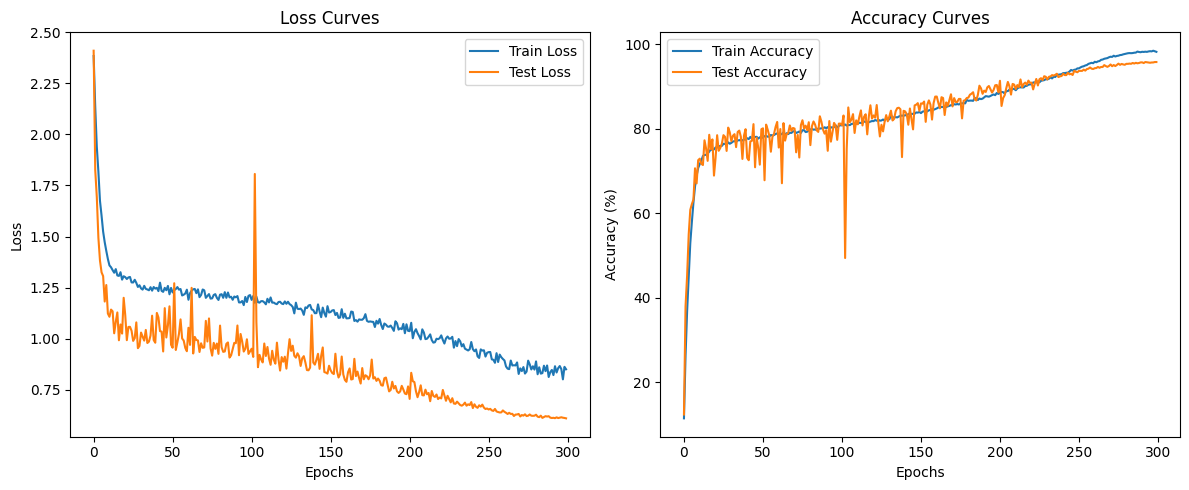

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [26]:
# Finalize the Model with SWA if Activated
final_model = model
if swa_active:
    print("\nUpdating batch norm stats for SWA model...")
    update_bn(train_loader, swa_model, device)
    swa_test_loss, swa_test_acc = evaluate(swa_model, test_loader, criterion, device)
    swa_train_loss, swa_train_acc = evaluate(swa_model, train_loader, criterion, device)
    print(f"SWA Train Loss: {swa_train_loss:.4f} | SWA Train Acc: {swa_train_acc:.2f}%")
    print(f"SWA Test Loss: {swa_test_loss:.4f} | SWA Test Acc: {swa_test_acc:.2f}%")
    
    if swa_test_acc > best_test_acc:
        print("SWA model outperforms the regular model. Using SWA model for predictions.")
        final_model = swa_model
        best_test_acc = swa_test_acc
        best_train_acc = swa_train_acc
    else:
        print("Regular model remains the best. Restoring best model weights.")
        model.load_state_dict(best_model_state)
        final_model = model
else:
    model.load_state_dict(best_model_state)
    final_model = model


Updating batch norm stats for SWA model...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/391 [00:00<?, ?it/s]

SWA Train Loss: 0.5445 | SWA Train Acc: 98.14%
SWA Test Loss: 0.6025 | SWA Test Acc: 95.87%
SWA model outperforms the regular model. Using SWA model for predictions.


## TTA
We use this to perform data augmentation on test images, and take the average of the predictions for each augmented variant of an image.

In [27]:
# Test-Time Augmentation and Submission
def tta_predict(model, images, num_augmentations=8):
    model.eval()
    with torch.no_grad():
        predictions = [model(images)]
        
        # Horizontal flip augmentation
        flipped = torch.flip(images, dims=[-1])
        predictions.append(model(flipped))
        
        # Small shifts
        shifts = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        for dx, dy in shifts[:min(4, num_augmentations-2)]:
            shifted = torch.roll(images, shifts=(dx, dy), dims=(-1, -2))
            predictions.append(model(shifted))
        
        # Slight brightness adjustments
        if len(predictions) < num_augmentations:
            brightened = torch.clamp(images * 1.05, 0, 1)
            predictions.append(model(brightened))
        if len(predictions) < num_augmentations:
            darkened = torch.clamp(images * 0.95, 0, 1)
            predictions.append(model(darkened))
        
        return torch.stack(predictions).mean(0)

In [28]:
# Generate predictions on the test set and create a submission CSV.
def predict_test_labels():
    test_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
    with open(test_file, 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
    
    print(f"Test data shape: {test_data[b'data'].shape}")
    
    test_images = test_data[b'data'].astype('float32') / 255.0
    test_images = np.transpose(test_images, (0, 3, 1, 2))
    test_tensor = torch.from_numpy(test_images).to(device)
    
    final_model.eval()
    predictions = []
    batch_size = 100
    with torch.no_grad():
        for i in range(0, test_tensor.size(0), batch_size):
            batch = test_tensor[i:i+batch_size]
            outputs = tta_predict(final_model, batch, num_augmentations=8)
            _, preds = outputs.max(1)
            predictions.extend(preds.cpu().numpy())
    
    submission = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions
    })
    submission.to_csv('submission2.csv', index=False)
    print("Submission file 'submission2.csv' created successfully!")
    return submission

## Prediction

Perform predictions and save the submission .csv file

In [29]:
print("\nCreating submission file...")
submission = predict_test_labels()
print(submission.head())


Creating submission file...
Test data shape: (10000, 32, 32, 3)
Submission file 'submission2.csv' created successfully!
   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9


## Training Summary

In [30]:
# Final Summary
print("\nFinal Model Summary:")
print(f"Trainable Parameters: {num_params:,}")
print(f"Best Train Accuracy: {best_train_acc:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Total Training Time: {training_time/60:.2f} minutes")


Final Model Summary:
Trainable Parameters: 4,988,974
Best Train Accuracy: 98.14%
Best Test Accuracy: 95.87%
Total Training Time: 263.07 minutes
